# Model Parameters Tutorial

### Caltech Summer 2019

This notebook demonstrates the effect of varying the parameters on the SED. Started 15 April 2020, and adapted from the Extinction Tutorial

### Imports 

In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy import integrate
import matplotlib.pyplot as plt

### Constants (astronomy is in cgs, right?)

In [2]:
G = 6.67259e-8
SIG_SB = 5.67051e-5
M_SUN = 1.99e33
R_SUN = 6.96e10
L_SUN = 3.839e33
h_PLANCK = 6.6260755e-27
c_LIGHT = 2.99792458e10
k_BOLTZ = 1.380658e-16

## Storing all functions (maybe do this in a separate .py file and import it?)

### Temperature profile functions

In the limit of steady accretion and being an optically thick disk, Hartmann and Kenyon (1996) provide
$$T^4 = \dfrac{3GM_* \dot{M}}{8\pi\sigma r^3}\Big[1 - \Big(\dfrac{r_i}{r}\Big)^{1/2}\Big] $$
where $R_i$ is the inner disk radius.

There is an obvious maximum temperature, $T_\text{max}$, that can be seen when plotting $T(r)$, which is unphysical, so setting all radii below $r_\text{max}$ to have that temperature is not an unreasonable first approximation.

In [3]:
def tempKepDisk(r, r_inner, m_dot, m_star):
    term1 = 3*G*m_star*m_dot / (8 * np.pi * SIG_SB * (r**3))
    term2 = (1 - (r_inner/r)**(1/2))
    return (term1 * term2)**(1/4)

def tempKepDiskNeg(r, r_inner, m_dot, m_star):
    return -tempKepDisk(r, r_inner, m_dot, m_star)

def findMaxTemp(r_inner, m_dot, m_star):
    res = minimize(tempKepDiskNeg, 2*r_inner, args=(r_inner, m_dot, m_star), method='Nelder-Mead')
    return (res.x[0], -res.fun)

def tempFUOriDisk(r, r_inner, m_dot, m_star):
    # Doesn't read in as arrays for some reason,
    # doing this element-wise...
    res = np.zeros(len(r))
    for i in range(len(r)):
        if r[i] <= findMaxTemp(r_inner, m_dot, m_star)[0]:
            res[i] = findMaxTemp(r_inner, m_dot, m_star)[1]
        else:
            res[i] = tempKepDisk(r[i], r_inner, m_dot, m_star)
    return res

### Annuli-generating functions

Currently setting as equal spacing out to the edge of the disk. Areas obviously get larger the farther out you go, but it may be wise to make the annuli widths a function of the distance from the center.

In [4]:
def generateDistArrays(r_inner, r_outer, r_sep):
    r_list = np.arange(r_inner, r_outer, r_sep)
    r_tup = []
    for i in range(len(r_list)-1):
        r_tup.append((r_list[i], r_list[i+1]))
    r_tup = np.array(r_tup)
    r_b = np.array([i[1] for i in r_tup])
    r_a = np.array([i[0] for i in r_tup])
    r_avg = np.mean(r_tup, axis=1)
    return (r_tup, r_avg, r_a, r_b)

In [5]:
def generateListDistArrays(points):
    r_list = points
    r_tup = []
    for i in range(len(r_list)-1):
        r_tup.append((r_list[i], r_list[i+1]))
    r_tup = np.array(r_tup)
    r_b = np.array([i[1] for i in r_tup])
    r_a = np.array([i[0] for i in r_tup])
    r_avg = np.mean(r_tup, axis=1)
    return (r_tup, r_avg, r_a, r_b)

### Luminosity functions

I calculate the luminosity of that annulus using (making sure to multiply the Planck function by $\pi$:):
$$L_\nu = A_\text{annulus}\cdot\pi\cdot\dfrac{2h \nu^3}{c^2}\dfrac{1}{\exp(\frac{h\nu}{k_B T}) - 1}$$
where $L_\nu$ is in erg/sec/Hz.

However, I need to make sure that I use 
$$A_\text{annulus} = 2\pi(r_b^2 - r_a^2)$$
where I will supply tuples of $(r_a, r_b)$, with the difference between the two increasing at farther distances from the center, and I will use the temperature at $r_\text{avg} \equiv (r_b - r_a)/2$.

Note that I can also use $L_\lambda$ appropriately as:
$$L_\lambda =A_\text{annulus}\cdot\pi\cdot B_\lambda= A_\text{annulus}\cdot\pi\cdot\dfrac{2hc^2}{\lambda^5}\dfrac{1}{\exp(\frac{hc}{\lambda k_B T}) - 1}$$
where $L_\lambda$ is in erg/sec/cm.

**Note**: The function is not immediately below, but is included within the class, for total luminosity of the accretion disk. 
$$j = \sigma T^4 \Longrightarrow L^\text{TOT} = \sigma\sum_{i}A_iT_i^4 $$
where the sum is over each annulus $i$.

In [6]:
def lumWaveAnnulus(wavelength, temp, r_b, r_a):
    term1 = 2*np.pi *(r_b**2 - r_a**2)
    term2 = 2*h_PLANCK*(c_LIGHT**2)*(wavelength**(-5))*np.pi
    term3 = (np.exp(h_PLANCK*c_LIGHT/(wavelength*k_BOLTZ*temp))-1)**(-1)
    return term1*term2*term3

def lumFreqAnnulus(freq, temp, r_b, r_a):
    term1 = 2*np.pi *(r_b**2 - r_a**2)
    term2 = 2*h_PLANCK*(c_LIGHT**(-2))*(freq**3)*np.pi
    term3 = (np.exp(h_PLANCK*freq/(k_BOLTZ*temp))-1)**(-1)
    return term1*term2*term3

## Setting up the class FUOri

In [7]:
class FUOri:

    # Initializer / Instance Attributes
    def __init__(self, r_star, r_inner, r_outer, m_star, m_dot):
        self.r_star = r_star
        self.r_inner = r_inner
        self.r_outer= r_outer
        self.m_star = m_star
        self.m_dot = m_dot
        
        # Distance arrays
        self.distances = 0
        
        # KHH88 "true vales"
        self.true_rad = 0
        self.true_temp = 0
        self.true_fluxes = 0

    # instance methods
    
    # Setting the distance arrays, DO THIS FIRST!
    def makeDistArrays(self, r_sep):
        self.distances = generateDistArrays(self.r_inner, self.r_outer, r_sep)
        
    def makeListDistArrays(self, points):
        self.distances = generateListDistArrays(points)
    
    # Assigning "true" values from KHH88
    def assignTrueTable(self, rad, temp, fluxes):
        self.true_rad = rad
        self.true_temp = temp
        self.true_fluxes = fluxes
    
    # T(r) of each annulus
    def getTemperature(self):
        r = self.distances[1]
        return tempFUOriDisk(r, self.r_inner, self.m_dot, self.m_star)

    # Luminosity contribution of each annulus
    def getLuminosityWave(self, wave):
        r_tup, r_avg, r_a, r_b = self.distances
        temps = self.getTemperature()
        return lumWaveAnnulus(wave, temps, r_b, r_a)
    
    def getLuminosityFreq(self, freq):
        r_tup, r_avg, r_a, r_b = self.distances
        temps = self.getTemperature()
        return lumFreqAnnulus(freq, temps, r_b, r_a)
    
    # Model spectrum
    def getModelSpectrumWave(self, wave_lower, wave_upper):
        r_tup, r_avg, r_a, r_b = self.distances
        waves = np.linspace(wave_lower, wave_upper, 100000)
        temp = tempFUOriDisk([r_avg[0]], self.r_inner, self.m_dot, self.m_star)
        lum = lumWaveAnnulus(waves, temp, r_b[0], r_a[0])
        for i in range(1,len(r_avg)):
            temp = tempFUOriDisk([r_avg[i]], self.r_inner, self.m_dot, self.m_star)
            lum += lumWaveAnnulus(waves, temp, r_b[i], r_a[i])
        return (waves,lum)

    # Total luminosity
    def getTotalLuminosity(self):
        r_tup, r_avg, r_a, r_b = self.distances
        lumTot = 0
        for i in range(len(r_avg)):
            temp = tempFUOriDisk([r_avg[i]], self.r_inner, self.m_dot, self.m_star)
            lumTot += 2*np.pi*(r_b[i]**2 - r_a[i]**2)*SIG_SB*temp**4
        return lumTot[0]
    
    # "True values" from KHH88:
    def getTrueTempProfile(self):
        return (self.true_rad, self.true_temp)
    
    def getTrueFracFluxes(self, col):
        return self.true_fluxes[:,col]

# Making an instance of the class FUOri as Gaia 17bpi

Crucial when plotting flux instead of luminosity:
$$F_\text{disk} = \dfrac{L_\text{disk, total}}{2\pi d^2}\cos i$$
see your notes for the derivation/explanation.

**Defining**: $\mu \equiv \dfrac{M_*/M_\odot}{R_*/R_\odot}$

In [8]:
M_STAR = 0.8*M_SUN
R_STAR = 2.0*R_SUN
R_OUTER = 100 * R_STAR
INC = 45
ACC_RATE = 1* 1e-5 * M_SUN / 3.154e7

In [9]:
gaia17bpi = FUOri(R_STAR, R_STAR, R_OUTER, M_STAR , ACC_RATE)
gaia17bpi_up = FUOri(R_STAR, R_STAR, R_OUTER, M_STAR , ACC_RATE)
gaia17bpi_down = FUOri(R_STAR, R_STAR, R_OUTER, M_STAR , ACC_RATE)


# Equal spacing of annuli
gaia17bpi.makeDistArrays(1*R_STAR)
gaia17bpi_up.makeDistArrays(1*R_STAR)
gaia17bpi_down.makeDistArrays(1*R_STAR)

In [10]:
modSpec = gaia17bpi.getModelSpectrumWave(0.01*1e-4, 1000*1e-4)
modSpec_up = gaia17bpi_up.getModelSpectrumWave(0.01*1e-4, 1000*1e-4)
modSpec_down = gaia17bpi_down.getModelSpectrumWave(0.01*1e-4, 1000*1e-4)

In [11]:
PATH = 'C:/Users/tonyc/OneDrive/Documents/2019 Summer/Papers/Gaia 17bpi/'

DIST = 1e3*3.08567758128e18

# Playing with Extinciton

Writing my own function because trying to decipher other people's code is annoying and often leads to poor understanding...

Functional form taken from Cardelli, Clayton, and Mathis (1989).

Reads in inverse microns

In [12]:
def calcExtinction(x, r):
    if 0. <= x <= 1.1:
        return 0.574*(x**1.61) - (0.527*(x**1.61))/r
    elif 1.1 < x <= 3.3:
        y = x - 1.82
        return 1 + 0.17699*y - 0.50447*(y**2) - 0.02427*(y**3) + 0.72085*(y**4) \
        + 0.01979*(y**5) - 0.77530*(y**6) + 0.32999*(y**7)\
        +(1.41338*y + 2.28305*(y**2) + 1.07233*(y**3) - 5.38434*(y**4)\
        - 0.62251*(y**5) + 5.30260*(y**6) - 2.09002*(y**7) )/r
    elif 3.3 < x <= 8:
        if 5.9 <= x <= 8:
            f_a = -0.04473*(x - 5.9)**2 - 0.009779*(x - 5.9)**3
            f_b = 0.2130*(x - 5.9)**2 + 0.1207*(x - 5.9)**3
        else:
            f_a = 0
            f_b = 0
            
        return 1.752 - 0.316*x - 0.104/((x - 4.67)**2 + 0.341) \
                + f_a + (-3.090 + 1.825*x + 1.206/((x - 4.62)**2 + 0.263) + f_b)/r
    else:
        return 0

Reads in Angstrom, and converts to inverse microns for the above function

In [13]:
def makeExtinctionCurve(waves, r):    
    waves_mod = 1/(waves*1e-4)
    return waves, np.array([calcExtinction(wave, r) for wave in waves_mod])  

In [14]:
a_V = 3

a_V_up = 4.5
a_V_down = 1.5

In [15]:
wav, lum = modSpec
wav_up, lum_up = modSpec_up
wav_down, lum_down = modSpec_down

a_lambda = a_V*makeExtinctionCurve(wav*1e8, 3.1)[1]
a_lambda_up = a_V_up*makeExtinctionCurve(wav_up*1e8, 3.1)[1]
a_lambda_down = a_V_down*makeExtinctionCurve(wav_down*1e8, 3.1)[1]

In [16]:
flux = np.cos(np.radians(INC))*lum/(2*np.pi*DIST**2)
flux_corrected = flux*(10**(-a_lambda/2.5))

In [17]:
flux_up = np.cos(np.radians(INC))*lum_up/(2*np.pi*DIST**2)
flux_up_corrected = flux_up*(10**(-a_lambda_up/2.5))

In [18]:
flux_down = np.cos(np.radians(INC))*lum_down/(2*np.pi*DIST**2)
flux_down_corrected = flux_down*(10**(-a_lambda_down/2.5))

In [19]:
0.75*0.8

0.6000000000000001

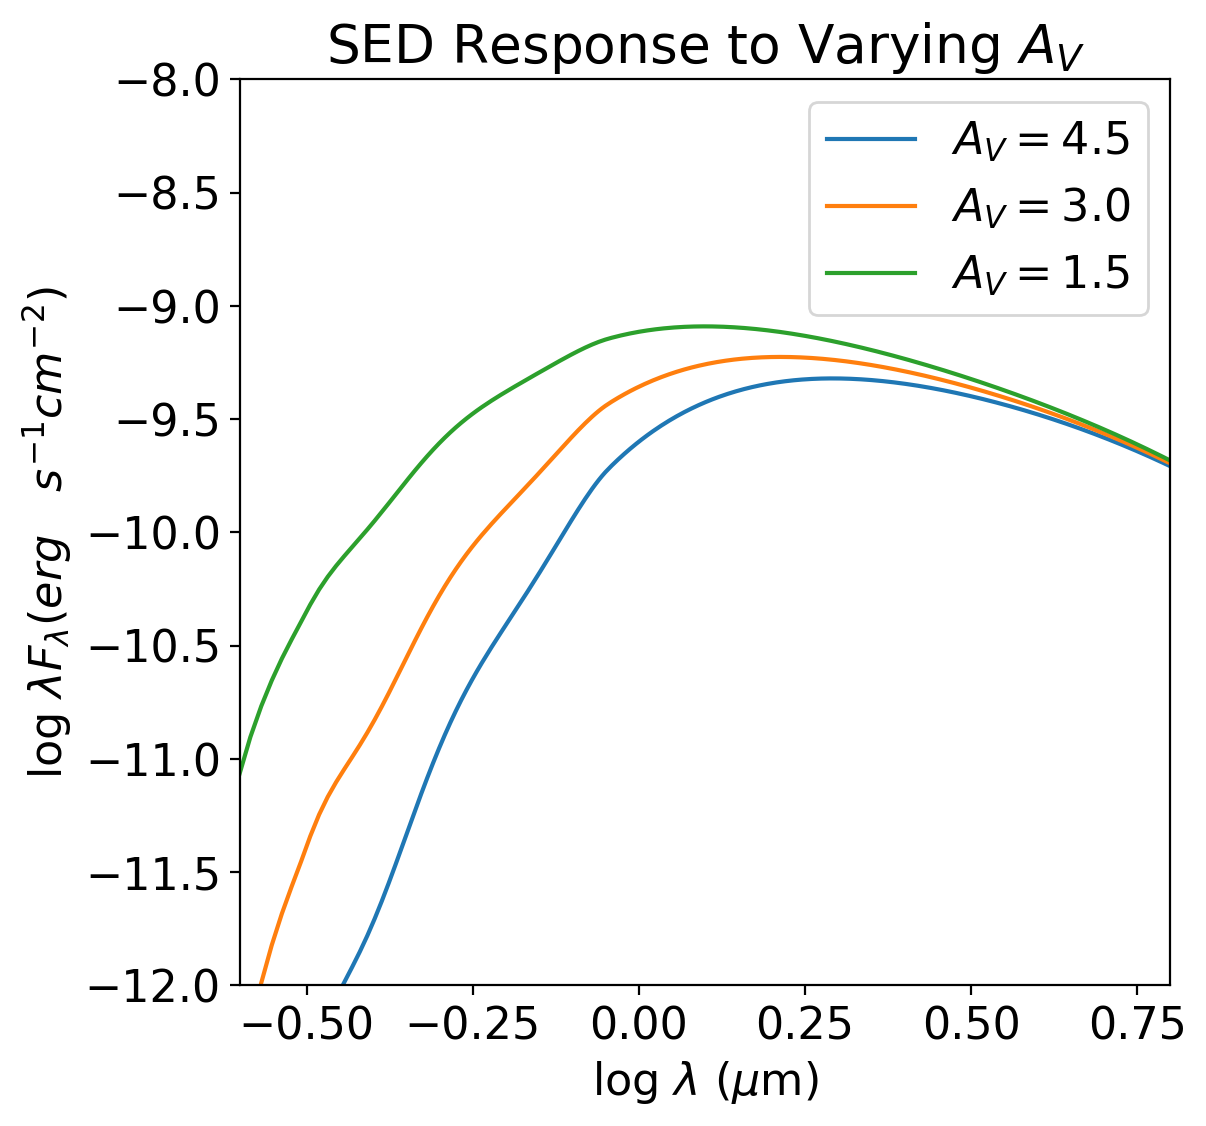

In [21]:
fig=plt.figure(figsize=(6, 6), dpi= 200)
plt.rcParams.update({'font.size': 16})
plt.plot(np.log10(wav_up*1e4), np.log10(flux_up_corrected*wav_up), \
         '-', label=r'$A_V = 4.5$')
plt.plot(np.log10(wav*1e4), np.log10(flux_corrected*wav), \
         '-', label=r'$A_V = 3.0$')
plt.plot(np.log10(wav_down*1e4), np.log10(flux_down_corrected*wav_down), \
         '-', label=r'$A_V = 1.5$')

plt.xlabel(r'log $\lambda$ ($\mu$m)')
plt.ylabel(r'log $\lambda F_\lambda (erg\quad s^{-1} cm^{-2})$')
plt.title(r'SED Response to Varying $A_V}$')
plt.ylim(-12, -8)
plt.xlim(-0.6, 0.8)
plt.legend()
# plt.savefig('sed_a_v_variation.png', dpi=200,  bbox_inches='tight')
plt.show()